# Leveraging NLP and Machine Learning to Understand Customer Sentiment

## A Study of Customer Reviews on Digital Products

Author: Dae Young Kim

---

In [136]:
import re
import pandas as pd
import numpy as np
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import torch
from transformers import BertTokenizer, BertModel
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/daeyoungkim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/daeyoungkim/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/daeyoungkim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/daeyoungkim/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [106]:
# function for classification report and confusion matrix
def get_class_result(y_test, y_pred, model_name):
    # Classification report -> DataFrame
    report = classification_report(y_test, y_pred, zero_division=1, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    
    # Side by side charts
    plt.figure(figsize=(14, 4))
    
    # Classification Report Table
    plt.subplot(1, 2, 1)
    plt.title(f'Classification Report - {model_name}', fontsize=14)
    plt.axis('off')
    table = plt.table(cellText=report_df.round(3).values, 
                      colLabels=report_df.columns, 
                      rowLabels=report_df.index, 
                      cellLoc='center', 
                      loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(16)
    table.scale(1.2, 1.5)
    
    # Confusion Matrix
    plt.subplot(1, 2, 2)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=model.classes_, 
                yticklabels=model.classes_,
                cbar=False,
                square=True,
                linewidths=0.5,
                annot_kws={"size": 14})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14)
    plt.xlabel('Predicted', fontsize=8)
    plt.ylabel('True', fontsize=8)
    plt.xticks(rotation=45, ha='right', fontsize=7)
    plt.yticks(fontsize=7)
    
    plt.tight_layout()
    plt.savefig(f'classification_report_and_confusion_matrix_{model_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

---
# Data Cleaning and Preparation
```
'Apex AD2600 Progressive-scan DVD player': 'data/customer review data/Apex AD2600 Progressive-scan DVD player.txt',
'Canon G3': 'data/customer review data/Canon G3.txt',
'Creative Labs Nomad Jukebox Zen Xtra 40GB': 'data/customer review data/Creative Labs Nomad Jukebox Zen Xtra 40GB.txt',
'Nikon coolpix 4300': 'data/customer review data/Nikon coolpix 4300.txt',
'Nokia 6610': 'data/customer review data/Nokia 6610.txt'
```

1) extract opinion features
2) clean review text
    - each review starts with the [t] tag, and each sentence begins with ##; using this structure, segment the text into individual reviews and sentences
    - [u], [p] tags mean that the feature is not completely present in the sentence (e.g. ##it has a nice color screen . size[+1][u], ##I love it! battery[p])
        - can still use them in the analysis, since the features are annotated with scores
        - if there might be no need to include them in the analysis, simply removing them could be straigtforward
    - [s],[cs],[cc] not found
    - normalize the text and removed stop words, leaving only words useful for sentiment analysis
4) combine the results and save in dataframe

In [2]:
# Function to load data
def read_data(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            file_content = file.read()
        # print(file_content)
        return file_content
    except FileNotFoundError:
        print(f"The file {file_path} does not exist.")

# Preprocess and structure each review
# For review segmentation and tag-based structuring
# - Each review starts with the [t] tag, and each sentence begins with ##
# - Using this structure, segment the text into individual reviews and sentences
def preprocess_reviews(data, product):
    
    # Split the data into individual reviews based on '[t]' tags
    reviews = [review for review in data.split('[t]') if review.strip()]
    print(f'{product}: {len(reviews)}')
    
    # List to store each processed review
    processed_reviews = []
    
    # For each review, split sentences and extract important information
    for review in reviews:
        sentences = review.split('##') # each sentence starts with '##'
        review_text = "" # variable to store the cleaned review text
        features = [] # list to store features with sentiment information
    
        for sentence in sentences:
            # Keep only the text and clean it
            # remove all [u] and [p] tags from sentences
            # sentence = re.sub(r'\[u\]|\[p\]', '', sentence) 
            # remove tags
            sentence_text = re.sub(r'\[.*?\]', '', sentence).strip() 
                # removing everything within and including the square brackets
                # - \[: matches the literal '[' character
                # - .*?: matches any character (.) zero or more times (*), 
                #        but as few times as possible (?), in a non-greedy manner
                # - \]`: matches the literal ']' character
                # if sentence = "example[+1], test[-2], code[+3]" --> output: example, test, code
            review_text += sentence_text + " "
    
            # Extract feature-sentiment pairs
            # Keeping feature information in JSON format for now
            features_in_sentence = re.findall(r'(\w+)\[([+-])(\d)\]', sentence) # find feature, polarity, and strength using patterns within square brackets
                # returns all non-overlapping matches of the pattern in the string as a list of tuples; each tuple contains the captured groups
                # so, from a sentence with matches like word[+1], get a list of tuples with the word, the sign, and the digit
                # - (\w+): matches one or more word characters (letters, digits, and underscores) and captures them in a group
                # - \[: matches the literal '[' character
                # - ([+-]): matches a single '+' or '-' character and captures it in a group
                # - (\d): matches a single digit and captures it in a group
                # - \]`: atches the literal ']' character
                # if sentence = "example[+1], test[-2], code[+3]" --> output: [('example', '+', '1'), ('test', '-', '2'), ('code', '+', '3')]
            for feature, polarity, strength in features_in_sentence:
                features.append({
                    "feature": feature,
                    "polarity": 1 if polarity == '+' else -1,
                    "strength": int(strength)
                })
    
        # Add the cleaned review data to the list, along with source name
        processed_reviews.append({
            "review": review_text.strip(),
            "features": features,
            "product": product
        })
    
    return processed_reviews

# Clean and normalize the text and removed stop words
# leaving only words useful for sentiment analysis
def preprocess_text(text):
    # convert text to lowercase
    text = text.lower()
    # remove unnecessary characters (punctuation and special characters)
    text = re.sub(r'[^\w\s]', '', text) # 
    # tokenize text and remove stop words
    tokens = nltk.word_tokenize(text)
    # lemmatize e.g. rocks -> rock, better -> good
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [3]:
# Stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Read all datasets and apply preprocessing
file_paths = {
    'Apex DVD': 'data/customer review data/Apex AD2600 Progressive-scan DVD player.txt',
    'Canon Camera': 'data/customer review data/Canon G3.txt',
    'Creative MP3': 'data/customer review data/Creative Labs Nomad Jukebox Zen Xtra 40GB.txt',
    'Nikon Camera': 'data/customer review data/Nikon coolpix 4300.txt',
    'Nokia Phone': 'data/customer review data/Nokia 6610.txt'
}

all_reviews = []
for product, path in file_paths.items():
    data = read_data(path)
    processed_reviews = preprocess_reviews(data, product) # process reviews
    processed_reviews = processed_reviews[1:] # exclude the first row
    all_reviews.extend(processed_reviews) # compile them

df = pd.DataFrame(all_reviews) # to DataFrame

# Apply text preprocessing to review texts
df['review_cleaned'] = df['review'].apply(preprocess_text)

# Save as csv
# df.to_csv('data/combined_customer_reviews.csv', index=False)

print(df.shape)
df.head(3)

Apex DVD: 100
Canon Camera: 46
Creative MP3: 96
Nikon Camera: 35
Nokia Phone: 42
(314, 4)


,review,features,product,review_cleaned
0,troubleshooting ad-2500 and ad-2600 no picture...,"[{'feature': 'button', 'polarity': 1, 'strengt...",Apex DVD,troubleshooting ad2500 ad2600 picture scrollin...
1,incredibe price / performance . i 've owned 6 ...,"[{'feature': 'player', 'polarity': 1, 'strengt...",Apex DVD,incredibe price performance owned 6 7 dvd play...
2,"doesnt play new disney movies . \nplay, disney...","[{'feature': 'play', 'polarity': -1, 'strength...",Apex DVD,doesnt play new disney movie play disney movie...


In [4]:
df['product'].value_counts()

product
Apex DVD        99
Creative MP3    95
Canon Camera    45
Nokia Phone     41
Nikon Camera    34
Name: count, dtype: int64

---
# Target Labeling

- label the target sentiment for each review as positive, negative, or neutral, based on the overall sentiment score
    - if the total positive sentiment score exceed the negative score -> positive
    - if negative score is higher -> negative
    - if equal -> neutral

In [5]:
# Class labeling function
def label_class(features):
    # Extract strengths for positive and negative sentiments
    positive_strengths = [f['strength'] for f in features if f['polarity'] == 1]
    negative_strengths = [f['strength'] for f in features if f['polarity'] == -1]

    # Calculate total scores for positive and negative sentiments
    positive_score = sum(positive_strengths)
    negative_score = sum(negative_strengths)
    
    # positive_score = sum(score * score for score in positive_strengths) # strength^2
    # negative_score = sum(score * score for score in negative_strengths)
    
    # positive_score = sum(score + len(positive_strengths) for score in positive_strengths) # strength + number of strengths
    # negative_score = sum(score + len(negative_strengths) for score in negative_strengths)

    # use total average instead?

    # Compare total scores to determine overall sentiment
    if positive_score > negative_score:
        return 'positive'
    elif negative_score > positive_score:
        return 'negative'
    else:
        # Resolve neutrality by comparing the maximum individual strengths
        # If both strengths are equal, default to 'positive'
        if max(positive_strengths, default=0) >= max(negative_strengths, default=0):
            return 'positive'
        else:
            return 'negative'

- This approach prioritizes the strength of sentiment when determining the overall sentiment of a review. Instead of labeling a review as neutral when the total positive and negative sentiment scores are equal, we break the tie by comparing the highest individual strength scores for each polarity. For example, if the strongest positive sentiment is equal to or higher than the strongest negative sentiment, the review is labeled as positive; otherwise, it is labeled as negative. This method ensures that reviews with clear strong feelings are not misclassified as neutral, making the sentiment classification more intuitive and aligned with the intensity of customer opinions.

In [6]:
# add sentiment labels to each review
df['sentiment'] = df['features'].apply(label_class)
df.head()

,review,features,product,review_cleaned,sentiment
0,troubleshooting ad-2500 and ad-2600 no picture...,"[{'feature': 'button', 'polarity': 1, 'strengt...",Apex DVD,troubleshooting ad2500 ad2600 picture scrollin...,positive
1,incredibe price / performance . i 've owned 6 ...,"[{'feature': 'player', 'polarity': 1, 'strengt...",Apex DVD,incredibe price performance owned 6 7 dvd play...,positive
2,"doesnt play new disney movies . \nplay, disney...","[{'feature': 'play', 'polarity': -1, 'strength...",Apex DVD,doesnt play new disney movie play disney movie...,negative
3,poor quality - problem with dual-layer dvd 's ...,"[{'feature': 'dvd', 'polarity': -1, 'strength'...",Apex DVD,poor quality problem duallayer dvd duallayer d...,negative
4,has destroyed several of my dvds and cds . \nc...,"[{'feature': 'case', 'polarity': 1, 'strength'...",Apex DVD,destroyed several dvd cd case first week playe...,negative


- the model did not predict neutral at all; so changed the logic not to include any neutral label
- will be only using positive vs. negative

In [7]:
df['sentiment'].value_counts()

sentiment
positive    203
negative    111
Name: count, dtype: int64

# Exploratory Data Analysis (EDA)

Distribution of Reviews by Source (Product Type)
- The bar chart shows the number of reviews for each product.
- This helps understand which products receive the most attention.

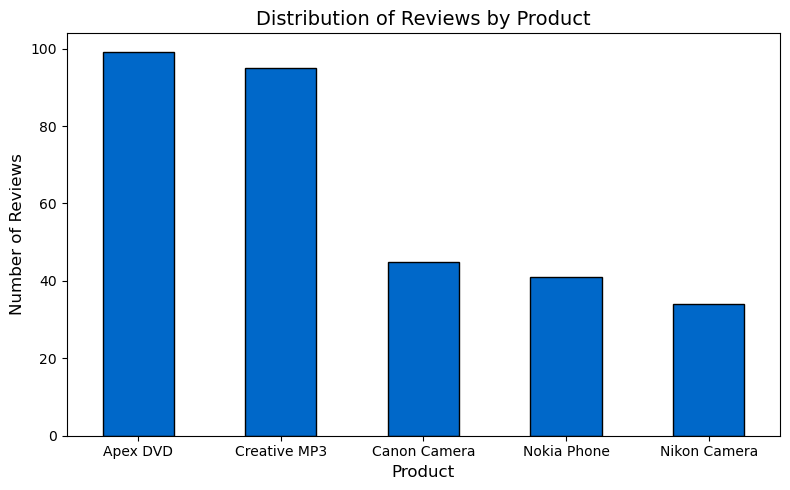

In [8]:
# df = pd.read_csv('data/combined_customer_reviews.csv')

# Plot the distribution of reviews by source (product)
plt.figure(figsize=(8, 5))
df['product'].value_counts().plot(kind='bar', color='#0068C9', edgecolor='black')
plt.title('Distribution of Reviews by Product', fontsize=14)
plt.xlabel('Product', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
# plt.savefig('review_distribution_by_product.png') # Save for report
plt.show()

Observations:
1) The product that gets the most attention is the DVD player and the jukebox

Sentiment Polarity Distribution
- shows the count of reviews classified as positive, negative, or neutral
- provides a quick overview of the general sentiment trends in the dataset

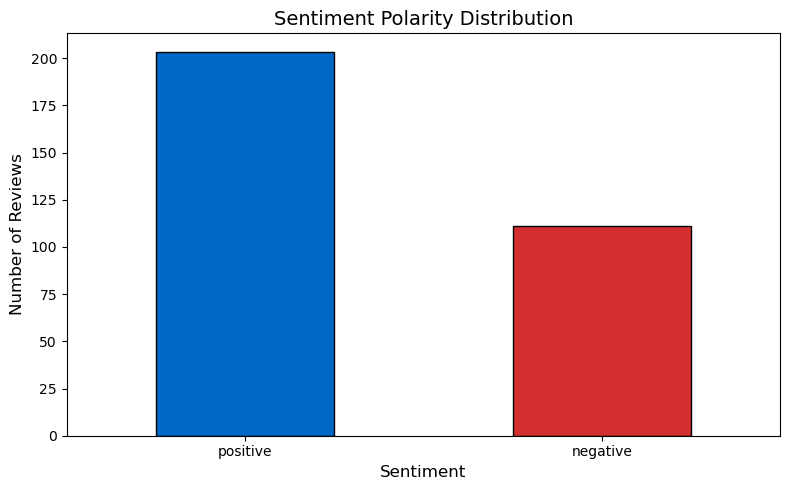

In [9]:
# Plot the distribution of sentiment polarity
plt.figure(figsize=(8, 5))
colors = ['#0068C9','#D32F2F']
df['sentiment'].value_counts().plot(kind='bar', color=colors, edgecolor='black')
plt.title('Sentiment Polarity Distribution', fontsize=14)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
# plt.savefig('sentiment_polarity_distribution.png') # Save for report
plt.show()

Observations:
1) There are more positive reviews than negative reviews in the dataset.

Sentiment Distribution Across Products
- Stacked bar chart showing the proportion of positive, negative, and neutral sentiments for each product category
- distribution of sentiments (positive, negative, neutral) for each product category

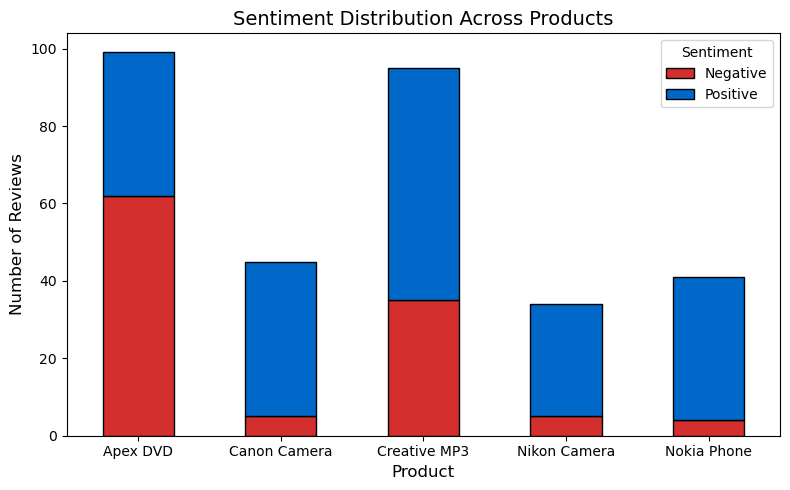

In [10]:
# Sentiment distribution by product source
sentiment_product = df.groupby(['product', 'sentiment']).size().unstack().copy()

# Plotting
colors = ['#D32F2F', '#0068C9']
sentiment_product.plot(kind='bar', stacked=True, figsize=(8, 5), color=colors, edgecolor='black')
plt.title('Sentiment Distribution Across Products', fontsize=14)
plt.xlabel('Product', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Sentiment', labels=['Negative', 'Positive'], loc='upper right')
plt.tight_layout()
# plt.savefig('sentiment_distribution_across_products.png') # Save for report
plt.show()

Observations:
1) Almost every product has more positive reviews than negative ones, except for the DVD player, which has more negative reviews.
2) Products from Canon, Nikon and Nokia generally receive mostly positive reviews.

Feature Sentiment Analysis
- Visualization of the top 10 most mentioned product features, separated by positive and negative sentiment.
- Analyze the most frequently mentioned features and their associated sentiments

In [13]:
feature_sentiments[:2]

[('button', 1), ('player', 1)]

In [108]:
feature_counts.head(2)

,feature,-1,1
0,0,0,3
1,1220,1,0


In [109]:
feature_counts_filtered.head(2)

,-1,1
feature,,
0,0,3
1220,1,0


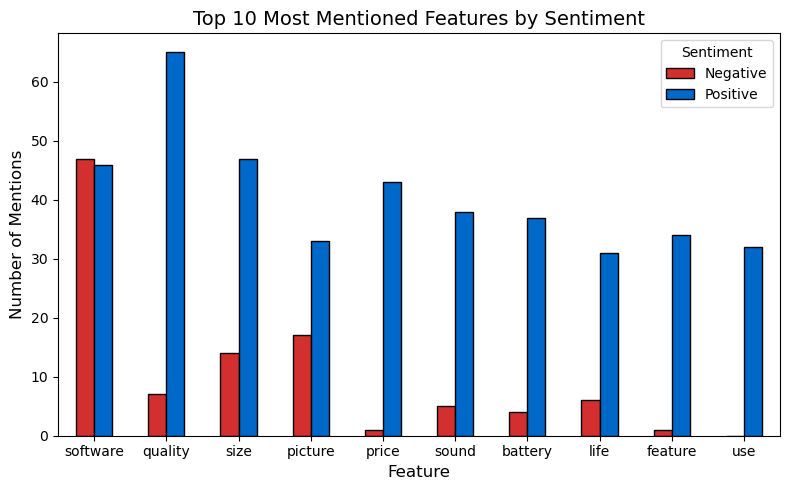

In [11]:
# Extract features and sentiment counts
# First get all feature - polarity pairs
feature_sentiments = []
for features in df['features']:
    if isinstance(features, list): # Check if features is a list
        for feature in features:
            feature_sentiments.append((feature['feature'], feature['polarity'])) # feature - polarity pairs
    else:
        raise TypeError("Expected a list for 'features' column, but got a different type.")

# Count positive and negative mentions for each feature
feature_counts = pd.DataFrame(feature_sentiments, columns=['feature', 'polarity'])
feature_counts = feature_counts.groupby(['feature', 'polarity']).size().unstack(fill_value=0) # feature - negative count - positive count
feature_counts = feature_counts.reset_index().rename_axis(None, axis=1)

# Exclude specific features
exclude_features = ['player', 'camera', 'phone', 'one', 'nt']
feature_counts_filtered = feature_counts[~feature_counts['feature'].isin(exclude_features)].copy()
feature_counts_filtered = feature_counts_filtered.set_index('feature')

# Plot the top 10 features
top_features = feature_counts_filtered.sum(axis=1).sort_values(ascending=False).head(10)
top_features_df = feature_counts_filtered.loc[top_features.index]

# Plotting
colors = ['#D32F2F', '#0068C9']
top_features_df.plot(kind='bar', figsize=(8, 5), color=colors, edgecolor='black') # colormap='Set2'
plt.title('Top 10 Most Mentioned Features by Sentiment', fontsize=14)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Number of Mentions', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Sentiment', labels=['Negative', 'Positive'], loc='upper right')
plt.tight_layout()
# plt.savefig('top_features_sentiment.png') # Save for report
plt.show()

Observations:

<i>*Features excluded: player, camera, phone</i>

1) The top 10 feature-by-sentiment chart shows that customers are generally satisfied with features like quality, size, price, sound, battery, and usability.
2) However, significant negative reviews for software, size, and picture features indicate areas where customers are experiencing dissatisfaction, suggesting these are key areas for potential improvement.

Common Words in Positive and Negative Reviews
- The word clouds highlight the most frequent words in positive and negative reviews, giving an intuitive sense of what customers like or dislike.

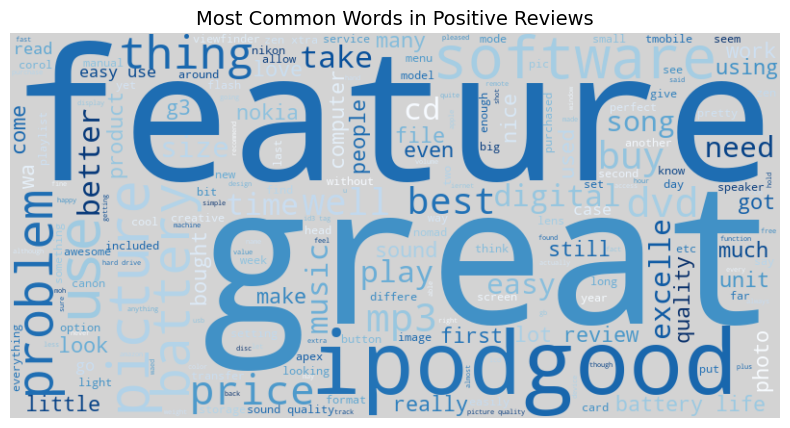

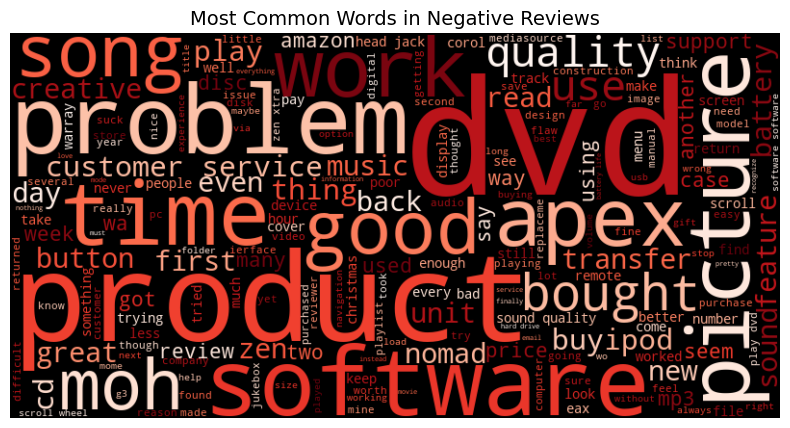

In [12]:
# Generate word clouds for positive and negative reviews
positive_reviews = ' '.join(df[df['sentiment'] == 'positive']['review_cleaned'])
negative_reviews = ' '.join(df[df['sentiment'] == 'negative']['review_cleaned'])

exclude_features = ['player', 'camera', 'phone', 'one', 'nt']
for feature in exclude_features:
    positive_reviews = positive_reviews.replace(feature, '')
    negative_reviews = negative_reviews.replace(feature, '')

# Positive wordcloud
positive_wordcloud = WordCloud(width=800, height=400, background_color='lightgray', colormap='Blues').generate(positive_reviews)
plt.figure(figsize=(8, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Positive Reviews', fontsize=14)
plt.tight_layout()
# plt.savefig('positive_wordcloud.png') # Save for report
plt.show()

# Negative wordcloud
negative_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_reviews)
plt.figure(figsize=(8, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Negative Reviews', fontsize=14)
plt.tight_layout()
# plt.savefig('negative_wordcloud.png') # Save for report
plt.show()

Observations:

<i>*Features excluded: player, camera, phone</i>

1) Common words in positive reviews: feature, great, ipod, good, software, use, picture, price, battery
2) Common words in negative reviews: dvd, product, software, problem, product, time, work, and song

Common Features by Sentiment
- Separate bar charts for the most frequently mentioned features in positive and negative reviews
- Highlight the most frequently mentioned features in positive and negative reviews separately

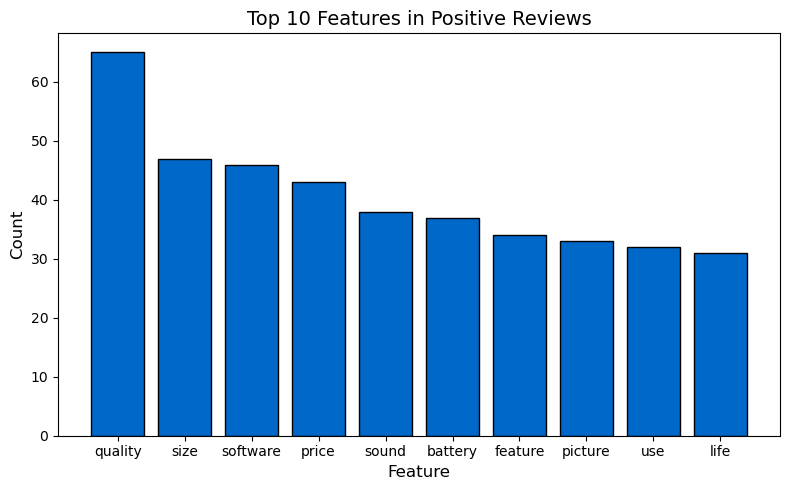

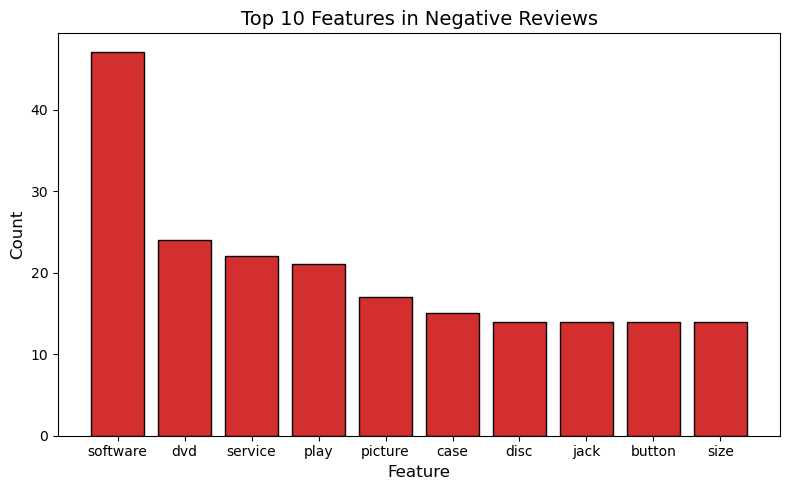

In [13]:
# Separate positive and negative features
positive_features = feature_counts.loc[feature_counts.index].reset_index().copy()
negative_features = feature_counts.loc[feature_counts.index].reset_index().copy()

# Exclude specific features
exclude_features = ['player', 'camera', 'phone', 'one', 'nt']
positive_features = positive_features[~positive_features['feature'].isin(exclude_features)]
negative_features = negative_features[~negative_features['feature'].isin(exclude_features)]

# Top 10 positive features
top_positive = positive_features.sort_values(by=1, ascending=False).head(10)

# Top 10 negative features
top_negative = negative_features.sort_values(by=-1, ascending=False).head(10)

# Plot positive features
plt.figure(figsize=(8, 5))
plt.bar(top_positive['feature'], top_positive[1], color='#0068C9', edgecolor='black')
plt.title('Top 10 Features in Positive Reviews', fontsize=14)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
# plt.savefig('top_positive_features.png') # Save for report
plt.show()

# Plot negative features
plt.figure(figsize=(8, 5))
plt.bar(top_negative['feature'], top_negative[-1], color='#D32F2F', edgecolor='black')
plt.title('Top 10 Features in Negative Reviews', fontsize=14)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
# plt.savefig('top_negative_features.png') # Save for report
plt.show()

Observations:

<i>*Features excluded: player, camera, phone</i>

1) Top 10 features in positive reviews: quality, size, software, price, sound, battery, etc.
2) Top 10 features in negative reviews: software, dvd, service, play, picture, case, etc.

Length of Reviews vs. Sentiment
- Examine how review length correlates with sentiment

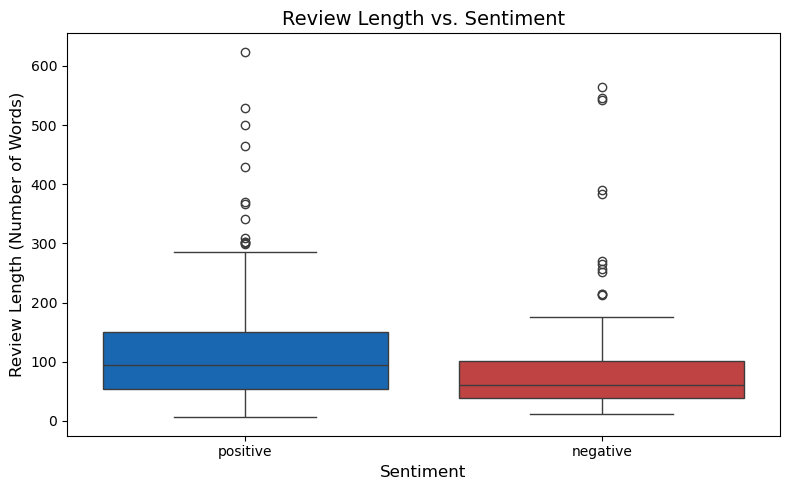

In [294]:
# Add a new column for review length
df['review_length'] = df['review_cleaned'].apply(lambda x: len(x.split()))

# Boxplot of review length by sentiment
plt.figure(figsize=(8, 5))
colors = ['#0068C9', '#D32F2F']
sns.boxplot(x='sentiment', y='review_length', data=df, hue='sentiment', palette=colors)
plt.title('Review Length vs. Sentiment', fontsize=14)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Review Length (Number of Words)', fontsize=12)
plt.tight_layout()
# plt.savefig('review_length_vs_sentiment.png') # Save for report
plt.show()

Observations:
1) The boxplot shows that positive reviews tend to be longer than negative reviews

Length of Reviews vs. Product
- Examine how review length correlates with product

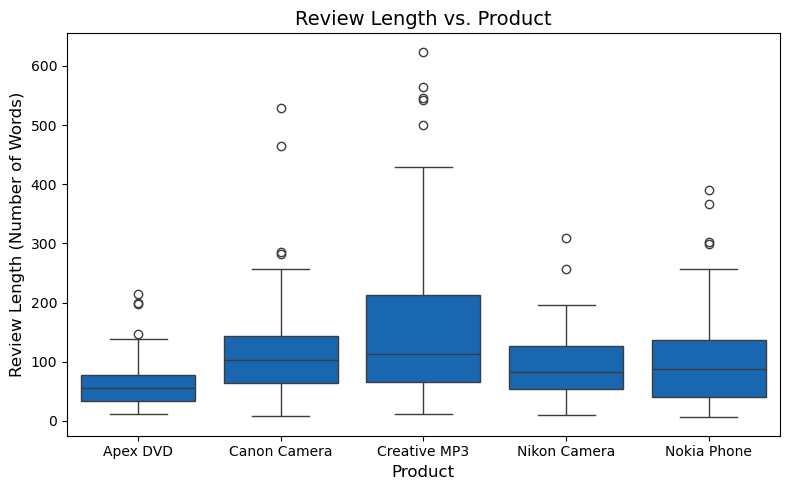

In [11]:
# Add a new column for review length
df['review_length'] = df['review_cleaned'].apply(lambda x: len(x.split()))

# Boxplot of review length by sentiment
plt.figure(figsize=(8, 5))
# colors = ['#0068C9', '#D32F2F']
sns.boxplot(x='product', y='review_length', data=df, color='#0068C9')
plt.title('Review Length vs. Product', fontsize=14)
plt.xlabel('Product', fontsize=12)
plt.ylabel('Review Length (Number of Words)', fontsize=12)
plt.tight_layout()
# plt.savefig('review_length_vs_sentiment.png') # Save for report
plt.show();

Observations:
1) The boxplot shows that MP3 reviews tend to be longer and DVD reviews tend to be shorter.

Correlation Between Features and Sentiment Strength

In [44]:
# Calculate sentiment metrics for each feature
weighted_strength = []

for features in df['features']: # each feature row
    for feature in features: # each feature item
        polarity = feature['polarity'] # Positive (1) or Negative (-1)
        strength = feature['strength'] # Strength (1, 2, 3)
        weighted_strength.append({
            "feature": feature['feature'], # feature term
            "polarity": polarity, # 1, -1
            "strength": strength, # 1, 2, 3
            "weighted_strength": polarity * strength, # Strength with polarity direction; 
            "abs_strength": abs(strength) # Absolute strength
        })

# Aggregate sentiment metrics by feature
weighted_strength_df = pd.DataFrame(weighted_strength)

feature_metrics = weighted_strength_df.groupby('feature').agg(
    # Total strength of positive polarity for each feature
    positive_score=pd.NamedAgg(column='strength', aggfunc=lambda x: sum(v for v, p in zip(x, weighted_strength_df['polarity']) if p == 1)),
    # Total strength of negative polarity for each feature
    negative_score=pd.NamedAgg(column='strength', aggfunc=lambda x: sum(v for v, p in zip(x, weighted_strength_df['polarity']) if p == -1)), 
    # Number of occurrences of positive polarity for each feature
    positive_count=pd.NamedAgg(column='polarity', aggfunc=lambda x: (x == 1).sum()),
    # Number of occurrences of negative polarity for each feature
    negative_count=pd.NamedAgg(column='polarity', aggfunc=lambda x: (x == -1).sum()),
    # Total net sentiment score (polarity × strength) for each feature
    net_sentiment_strength=pd.NamedAgg(column='weighted_strength', aggfunc='sum'),
    # Average weighted sentiment strength (polarity × strength) for each feature
    avg_sentiment_strength=pd.NamedAgg(column='weighted_strength', aggfunc='mean'),
    # Total absolute sentiment strength for each feature (sum of |strength|)
    total_abs_strength=pd.NamedAgg(column='abs_strength', aggfunc='sum')
).reset_index()

# Correlation analysis
correlation_data = feature_metrics.drop(columns=['feature']) # Select numeric columns only
correlation_matrix = correlation_data.corr()
print("Correlation Matrix for Features:")
correlation_matrix

Correlation Matrix for Features:


,positive_score,negative_score,positive_count,negative_count,net_sentiment_strength,avg_sentiment_strength,total_abs_strength
positive_score,1.000000,0.850573,0.917645,0.788320,0.607991,0.060297,0.955670
negative_score,0.850573,1.000000,0.907968,0.779505,0.612123,0.061652,0.967701
positive_count,0.917645,0.907968,1.000000,0.608697,0.832559,0.179883,0.948325
negative_count,0.788320,0.779505,0.608697,1.000000,0.080766,-0.188571,0.814395
net_sentiment_strength,0.607991,0.612123,0.832559,0.080766,1.000000,0.342424,0.634221
avg_sentiment_strength,0.060297,0.061652,0.179883,-0.188571,0.342424,1.000000,0.063428
total_abs_strength,0.955670,0.967701,0.948325,0.814395,0.634221,0.063428,1.000000


In [18]:
feature_metrics.head(2)

,feature,positive_score,negative_score,positive_count,negative_count,net_sentiment_score,total_abs_strength,avg_weighted_strength
0,0,8,0,3,0,8,8,2.666667
1,1220,2,0,0,1,-2,2,-2.000000


In [19]:
weighted_strength_df.head(2)

,feature,polarity,strength,weighted_strength,abs_strength
0,button,1,2,2,2
1,player,1,2,2,2


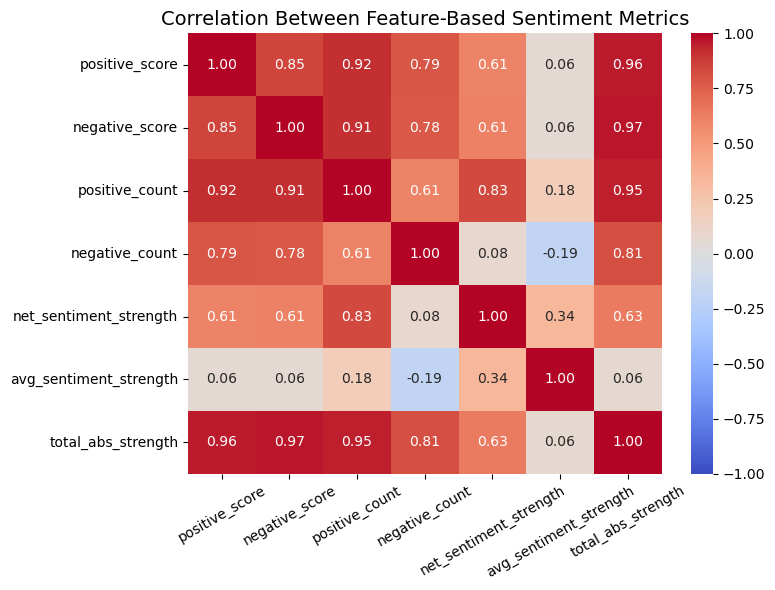

In [45]:
# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, vmin=-1, vmax=1, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Feature-Based Sentiment Metrics', fontsize=14)
plt.xticks(rotation=30)
plt.tight_layout()
# plt.savefig('feature_based_correlation_matrix.png') # Save the plot
plt.show();

Observations:
1) While most sentiment metrics show strong correlations with each other (0.6-0.9), the average sentiment strength exhibits remarkably weak correlations (0.06-0.18) with all other metrics, suggesting that the average intensity of individual sentiments moves independently from overall sentiment scores and frequencies.
    - A high volume of opinions or overall sentiment scores doesn't necessarily indicate strong individual sentiment expressions; we might see many mild opinions or few very strong ones, as the quantity and intensity of sentiments operate independently.
2) Total absolute strength's relationship shows strongest correlations with positive_score (0.96) and negative_score (0.97); however, has relatively weaker correlation with net_sentiment_strength (0.63). This implies that when the absolute intensity of sentiment expressions increases, the actual net directional sentiment (positive/negative) may not be as pronounced
    - High overall sentiment intensity doesn't necessarily translate to clear directional sentiment
3) Despite being opposing concepts, positive and negative scores show strong positive correlation. This indicates that when sentiment expression becomes intense, both positive and negative sentiments tend to increase together, suggesting potential polarization of opinions: when a topic becomes emotionally charged, it draws strong reactions in both directions.
    - Suggests that features tend to receive both positive and negative feedback simultaneously, rather than being exclusively positive or negative; indicates the complexity of feature evaluation and suggests the need for more nuanced analysis of feature-level sentiment patterns.
    - High emotional engagement tends to manifest in both positive and negative expressions simultaneously

Correlation Between Reviews and Sentiment Strength

In [46]:
# Function to calculate polarity scores, counts, and weighted strength for a review
def calculate_review_metrics(features):
    # Handle cases where features list might be empty
    if not features: 
        return pd.Series({
            "positive_score": 0,
            "negative_score": 0,
            "positive_count": 0,
            "negative_count": 0,
            "net_sentiment_score": 0,
            "avg_sentiment_score": 0,
            "total_abs_strength": 0
        })
    # Sum of positive polarity strengths in a review
    positive_score = sum(f['strength'] for f in features if f['polarity'] == 1)
    # Sum of negative polarity strengths in a review
    negative_score = sum(f['strength'] for f in features if f['polarity'] == -1)
    # Number of features with positive polarity (1) in a review
    positive_count = sum(1 for f in features if f['polarity'] == 1)
    # Number of features with negative polarity (-1) in a review
    negative_count = sum(1 for f in features if f['polarity'] == -1)
    # Total net sentiment score (polarity × strength) in a review
    net_sentiment_score = sum(f['polarity'] * f['strength'] for f in features)
    # Average net sentiment score for all features in a review
    avg_sentiment_score = net_sentiment_score / len(features) if features else 0 # if no features, set to 0
    # Total absolute sentiment strength (sum of |strength|) in a review
    total_abs_strength = sum(abs(f['strength']) for f in features)

    return pd.Series({
        "positive_score": positive_score,
        "negative_score": negative_score,
        "positive_count": positive_count,
        "negative_count": negative_count,
        "net_sentiment_score": net_sentiment_score,
        "avg_sentiment_score": avg_sentiment_score,
        "total_abs_strength": total_abs_strength
    })

# Apply the metrics calculation to the DataFrame
feature_df = df['features'].to_frame().copy()
review_metrics = feature_df['features'].apply(calculate_review_metrics)

# Combine the metrics back into the original DataFrame
feature_df = pd.concat([feature_df, review_metrics], axis=1)

# feature_df['absolute_net_sentiment_score'] = feature_df['net_sentiment_score'].abs()

# Correlation analysis
# Select relevant columns for correlation analysis
correlation_data = feature_df[['positive_score', 'negative_score', 'positive_count', 'negative_count', 
                               'net_sentiment_score', 'avg_sentiment_score', 'total_abs_strength']]
correlation_matrix = correlation_data.corr()

# Print the correlation matrix
print("Correlation Matrix:")
correlation_matrix

Correlation Matrix:


,positive_score,negative_score,positive_count,negative_count,net_sentiment_score,avg_sentiment_score,total_abs_strength
positive_score,1.000000,-0.056321,0.983667,0.079815,0.847852,0.561132,0.829672
negative_score,-0.056321,1.000000,-0.019482,0.964590,-0.577142,-0.558059,0.510637
positive_count,0.983667,-0.019482,1.000000,0.120144,0.814929,0.524288,0.836205
negative_count,0.079815,0.964590,0.120144,1.000000,-0.446986,-0.451178,0.608073
net_sentiment_score,0.847852,-0.577142,0.814929,-0.446986,1.000000,0.755345,0.407437
avg_sentiment_score,0.561132,-0.558059,0.524288,-0.451178,0.755345,1.000000,0.171194
total_abs_strength,0.829672,0.510637,0.836205,0.608073,0.407437,0.171194,1.000000


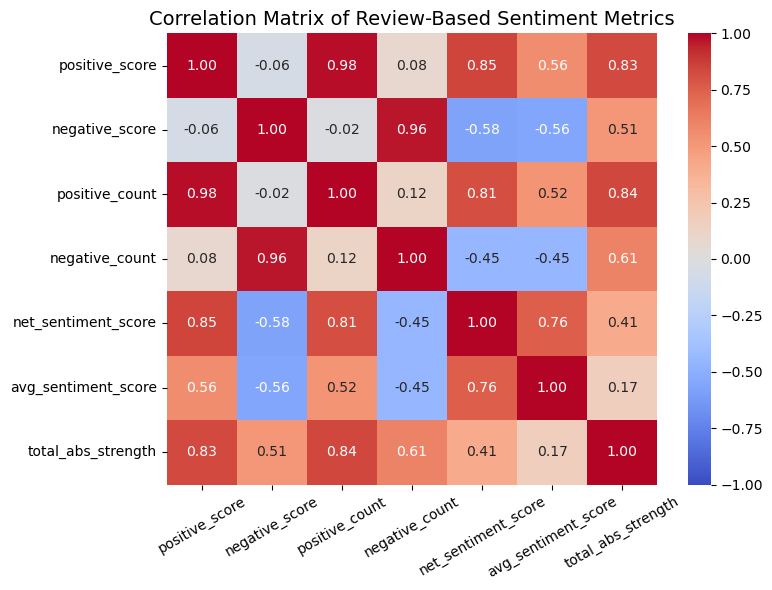

In [47]:
# Visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, vmin=-1, vmax=1, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Review-Based Sentiment Metrics', fontsize=14)
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('review_based_correlation_matrix.png') # Save the plot for reporting
plt.show()

Positive Count and Total Absolute Strength (Correlation = 0.836)
- Reviews with more positive features tend to show stronger overall emotional intensity (absolute strength). This indicates that positive reviews often express emotions more strongly, dominating in emotional strength compared to negative feedback

The contrast between feature-level and review-level correlations highlights the importance of context in sentiment analysis:
- At the feature level, the strong correlation between total_abs_strength and negative_score (0.967) suggests that negative feedback also plays a critical role in driving the intensity of sentiment for individual features. This indicates that certain features might face stronger criticism, and addressing these negative sentiments can provide focused improvement opportunities.
- Conversely, at the review level, the correlation between positive_count and total_abs_strength (0.836) shows that reviews with more and stronger positive features tend to exhibit stronger overall sentiment intensity (which may sound obvious or natural). This suggests that positive expressions are often more emotionally intense in holistic reviews, contributing more significantly to the perceived sentiment.

Together, these findings demonstrate complementary insights that are crucial for understanding customer sentiment: 
1) Feature-Level Analysis: This identifies areas requiring targeted enhancements by revealing how negative feedback often dominates sentiment intensity for specific features. It allows businesses to pinpoint and address critical pain points in their products, ensuring that the most pressing customer concerns are resolved effectively.
2) Review-Level Analysis: This highlights the significant role of positive sentiment in shaping the overall emotional intensity of reviews. Positive feedback contributes heavily to the perceived sentiment of a product or brand, emphasizing the need to foster positive customer experiences and strategically leverage them to enhance reputation and customer loyalty.

--> By combining these perspectives, companies can adopt a balanced strategy—improving weak points identified through feature analysis while amplifying the strengths and opportunities uncovered in review-level trends, ensuring both operational and reputational growth.

---
# Data Split

In [12]:
# Split data into features (X) and target (y)
X = df['review_cleaned']
y = df['sentiment']

X.head(2), y.head(2)

(0    troubleshooting ad2500 ad2600 picture scrollin...
 1    incredibe price performance owned 6 7 dvd play...
 Name: review_cleaned, dtype: object,
 0    positive
 1    positive
 Name: sentiment, dtype: object)

To prevent data leakage, do data split first, and then do feature extraction

In [13]:
# Split data into training and testing sets for model development
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=777)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(251,) (63,) (251,) (63,)


- stratified by target

In [14]:
print("Total Class Distribution:")
print(y.value_counts())

print("Training Set Class Distribution:")
print(y_train.value_counts())

print("\nTest Set Class Distribution:")
print(y_test.value_counts())

Total Class Distribution:
sentiment
positive    203
negative    111
Name: count, dtype: int64
Training Set Class Distribution:
sentiment
positive    162
negative     89
Name: count, dtype: int64

Test Set Class Distribution:
sentiment
positive    41
negative    22
Name: count, dtype: int64


- The dataset is imbalanced, and certain classes have very few examples.
- The model struggle to classify certain classes due to insufficient training data or feature representation. -> removed 'neutral' class from analysis/modeling
- balancing the imbalanced data may be considered

# Modeling and Evaluation: TF-IDF

## Feature Extractino: TF-IDF

In [53]:
# Use TF-IDF for feature extraction
tfidf = TfidfVectorizer(max_features=500) # , ngram_range=(1, 3)) # ngram applied
X_train_tfidf = tfidf.fit_transform(X_train)

# Transform the test data using the same TF-IDF transformer
X_test_tfidf = tfidf.transform(X_test)

print(X_train_tfidf.shape, X_test_tfidf.shape, y_train.shape, y_test.shape)

(251, 500) (63, 500) (251,) (63,)


- TF-IDF -> apply n-gram
- data split -> and then feature extraction

## Imbalance Handling

Balance the dataset
- Oversampling: Duplicate samples from minority classes
- Synthetic Data Generation: Use SMOTE (Synthetic Minority Oversampling Technique) to create synthetic samples for the minority classes

In [357]:
# Balance the training dataset

# Apply RandomOverSampler to balance the training data
# ros = RandomOverSampler(random_state=777)
# X_train_balanced, y_train_balanced = ros.fit_resample(X_train, y_train)

# Apply SMOTE to balance the training data
# smote = SMOTE(random_state=777)
# X_train_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf, y_train)

# print(pd.Series(y_train_balanced).value_counts())

sentiment
negative    162
positive    162
Name: count, dtype: int64


## Logistic Regression

In [57]:
# Logistic Regression
model = LogisticRegression(random_state=777)
model.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_tfidf)
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=1)) # zero_division=1: Sets undefined precision or recall values to 1 (default: 0)

Classification Report:
              precision    recall  f1-score   support

    negative       0.93      0.64      0.76        22
    positive       0.83      0.98      0.90        41

    accuracy                           0.86        63
   macro avg       0.88      0.81      0.83        63
weighted avg       0.87      0.86      0.85        63



## MultinomialNB

In [59]:
# Multinomial Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_pred_nb = nb_model.predict(X_test_tfidf)
print("MultinomialNB Classification Report:")
print(classification_report(y_test, y_pred_nb, zero_division=1))

MultinomialNB Classification Report:
              precision    recall  f1-score   support

    negative       0.83      0.68      0.75        22
    positive       0.84      0.93      0.88        41

    accuracy                           0.84        63
   macro avg       0.84      0.80      0.82        63
weighted avg       0.84      0.84      0.84        63



## RandomForestClassifier

In [60]:
# Random Forest
rf_model = RandomForestClassifier(random_state=777)
rf_model.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test_tfidf)
print("RandomForestClassifier Classification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=1))

RandomForestClassifier Classification Report:
              precision    recall  f1-score   support

    negative       0.92      0.50      0.65        22
    positive       0.78      0.98      0.87        41

    accuracy                           0.81        63
   macro avg       0.85      0.74      0.76        63
weighted avg       0.83      0.81      0.79        63



## SVM

In [61]:
# Support Vector Machine
svm_model = SVC(kernel='linear', random_state=777) # Using a linear kernel for simplicity
svm_model.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_pred_svm = svm_model.predict(X_test_tfidf)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm, zero_division=1))

SVM Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.64      0.72        22
    positive       0.83      0.93      0.87        41

    accuracy                           0.83        63
   macro avg       0.82      0.78      0.80        63
weighted avg       0.83      0.83      0.82        63



## XGBoost

In [62]:
# Encode target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train) # Encode 'positive' and 'negative' as integers
y_test_encoded = label_encoder.transform(y_test)

# XGBoost Model
xgb_model = XGBClassifier(eval_metric='logloss', random_state=777)
xgb_model.fit(X_train_tfidf, y_train_encoded)

# Predict and decode the results back to original labels
y_pred_xgb_encoded = xgb_model.predict(X_test_tfidf)
y_pred_xgb = label_encoder.inverse_transform(y_pred_xgb_encoded) # Decode predictions back to 'positive', 'negative'

# Evaluate and print the classification report
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb, zero_division=1))

XGBoost Classification Report:
              precision    recall  f1-score   support

    negative       0.75      0.55      0.63        22
    positive       0.79      0.90      0.84        41

    accuracy                           0.78        63
   macro avg       0.77      0.72      0.74        63
weighted avg       0.77      0.78      0.77        63



## Confusion Matrix

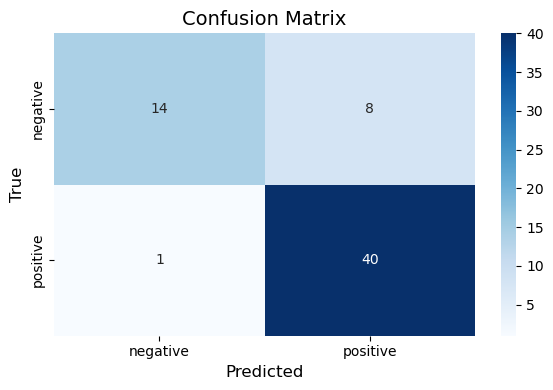

In [58]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png') # Save for report
plt.show()

- good performance on positive review prediction

## Compare Different Models
- Compare and collect the performance of different models
- Accuracy and F-1 Score
    - In addition to accuracy, focusing on the F1-Score due to class imbalance in the data.
    - The F1-Score provides a better evaluation of model performance when there is a significant class imbalance, as it balances precision and recall, especially in cases where false positives and false negatives are critical.
    - Macro-averaging considers all classes equally, even if they are imbalanced. It avoids bias toward majority classes.

In [63]:
# Encode target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(random_state=777),
    "MultinomialNB": MultinomialNB(),
    "RandomForest": RandomForestClassifier(random_state=777),
    "SVM": SVC(kernel='linear', random_state=777),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=777),
}

results = []

# Train and evaluate each model
for model_name, model in models.items():
    # Fit the model
    if model_name == "MultinomialNB": # MultinomialNB requires non-negative features
        model.fit(X_train_tfidf, y_train)
        y_pred = model.predict(X_test_tfidf)
    else:
        model.fit(X_train_tfidf, y_train_encoded)
        y_pred = model.predict(X_test_tfidf)
        if model_name != "MultinomialNB": # Decode predictions for all other models
            y_pred = label_encoder.inverse_transform(y_pred)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro', zero_division=1)
    
    # Store results
    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Macro F1-Score": macro_f1
    })

results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,Macro F1-Score
0,Logistic Regression,0.857143,0.827817
1,MultinomialNB,0.841270,0.816860
2,RandomForest,0.809524,0.758312
3,SVM,0.825397,0.795756
4,XGBoost,0.777778,0.736244


## Grid Search
- perform grid search for each of the models

In [53]:
# Conduct GridSerach

# Encode target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train) # Encode 'positive' and 'negative' as integers
y_test_encoded = label_encoder.transform(y_test)

# Define the parameter grids for each model
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100], # Regularization strength
    'solver': ['lbfgs', 'liblinear', 'saga'], # Solvers that work well for smaller datasets
    'max_iter': [100, 500, 1000]
}

param_grid_rf = {
    'n_estimators': [50, 100, 200, 300, 500], # Number of trees in the forest
    'max_depth': [None, 5, 10, 15, 20], # Maximum depth of the tree
    'min_samples_split': [2, 5, 10], # Minimum samples required to split an internal node
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

param_grid_svm = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100], # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], # SVM kernel types
    'class_weight': [None, 'balanced']
}

param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.3], # Step size at each iteration
    'n_estimators': [50, 100, 200, 300], # Number of boosting rounds
    'max_depth': [3, 5, 7, 10], # Maximum depth of the trees
    'scale_pos_weight': [1, 2, 3]
}

param_grid_nb = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0], # Smoothing parameter for Naive Bayes
    'fit_prior': [True, False]
}

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "MultinomialNB": MultinomialNB(),
    "RandomForest": RandomForestClassifier(random_state=777),
    "SVM": SVC(random_state=777),
    "XGBoost": XGBClassifier(random_state=777) # logloss, auc
}

# Dictionary to store results
results = []

# Function to perform grid search and evaluate each model
for model_name, model in models.items():
    if model_name == "Logistic Regression":
        param_grid = param_grid_lr
    elif model_name == "RandomForest":
        param_grid = param_grid_rf
    elif model_name == "SVM":
        param_grid = param_grid_svm
    elif model_name == "XGBoost":
        param_grid = param_grid_xgb
    elif model_name == "MultinomialNB":
        param_grid = param_grid_nb

    # Perform GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    if model_name == "MultinomialNB": # MultinomialNB requires non-negative features
        grid_search.fit(X_train_tfidf, y_train)
        best_model = grid_search.best_estimator_ # Best model after hyperparameter tuning
        y_pred = best_model.predict(X_test_tfidf) # Predict and evaluate the tuned model
    else:
        grid_search.fit(X_train_tfidf, y_train_encoded)
        best_model = grid_search.best_estimator_ 
        y_pred = best_model.predict(X_test_tfidf) 
        if model_name != "MultinomialNB": # Decode predictions for all other models
            y_pred = label_encoder.inverse_transform(y_pred)
    
    # grid_search.fit(X_train_tfidf, y_train_encoded)
    # # Best model after hyperparameter tuning
    # best_model = grid_search.best_estimator_
    # # Predict and evaluate the tuned model
    # y_pred = best_model.predict(X_test_tfidf)
    
    accuracy = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro', zero_division=1)
    
    # Store results
    results.append({
        "Model": model_name,
        "Best Parameters": grid_search.best_params_,
        "Accuracy": accuracy,
        "Macro F1-Score": macro_f1
    })

# Convert results to DataFrame for comparison
results_df = pd.DataFrame(results)
results_df

/opt/miniconda3/envs/cmse830/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/cmse830/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/cmse830/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/cmse830/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/cmse830/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/cmse830/lib/py

,Model,Best Parameters,Accuracy,Macro F1-Score
0,Logistic Regression,"{'C': 10, 'max_iter': 500, 'solver': 'saga'}",0.841270,0.816860
1,MultinomialNB,"{'alpha': 0.1, 'fit_prior': True}",0.825397,0.801148
2,RandomForest,"{'class_weight': 'balanced', 'max_depth': None...",0.825397,0.789554
3,SVM,"{'C': 1, 'class_weight': None, 'kernel': 'line...",0.825397,0.795756
4,XGBoost,"{'learning_rate': 0.3, 'max_depth': 10, 'n_est...",0.793651,0.764993


- general approaches perform better than grid search method

## Ensemble Models

Ensemble Models
- Each model learns different patterns in the data, so the more diverse the models, the more likely the ensemble will perform better
- Combining tree-based models and linear models can lead to better results

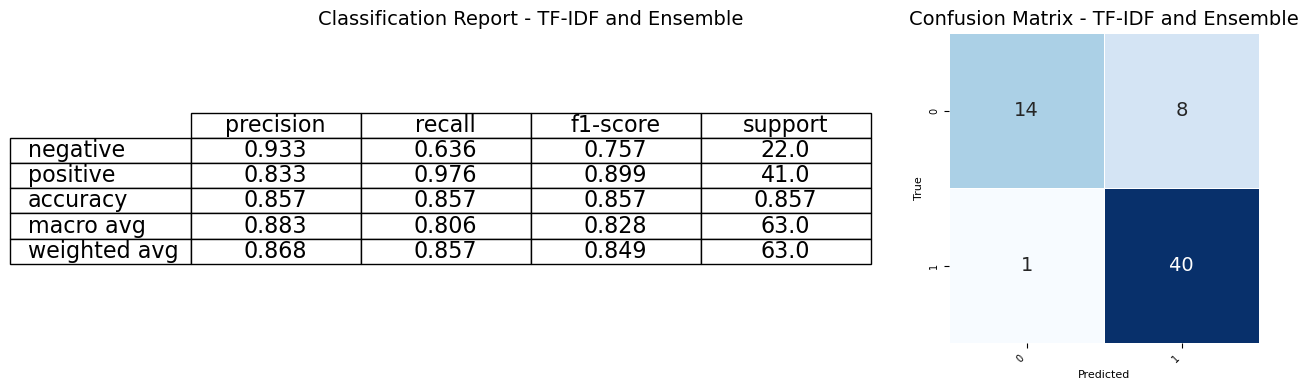

In [135]:
# Apply ensemble methods
classifiers = [
    ('lr', LogisticRegression(max_iter=100, random_state=777)), # Logistic Regression
    ('svm', SVC(random_state=777)), # Support Vector Machine
    ('rf', RandomForestClassifier(n_estimators=100, random_state=777)), # Random Forest
    ('xgb', XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=777)), # XGBoost
    ('knn', KNeighborsClassifier(n_neighbors=5)), # K-Nearest Neighbors
]

# Soft voting ensemble
ensemble_clf = VotingClassifier(
    estimators=classifiers, 
    voting='hard',
    n_jobs=-1
)

# Train ensemble classifier
ensemble_clf.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_pred = ensemble_clf.predict(X_test_tfidf)

get_class_result(y_test, y_pred, 'TF-IDF and Ensemble')

# Modeling and Evaluation: BERT

## Feature Extractoin: BERT

```
conda install conda-forge::transformers
conda install pytorch::pytorch
```

Using BERT as a feature extractor combined with a logistic regression classifier
- Utilization of BERT's powerful embeddings + simplicity and interpretability of logistic regression
- Reduced risk of overfitting

In [107]:
# Load the pre-trained BERT tokenizer and model (BERT-base, uncased version)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Function to extract BERT embeddings for a list of texts
def extract_bert_features(texts):
    features = [] # List to store extracted features
    for text in texts:
        # Tokenize and encode the input text into tensors
        inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=256, padding=True)
        # Disable gradient calculations for inference
        with torch.no_grad():
            outputs = bert_model(**inputs) # Get outputs from the BERT model
        # Compute the mean of the last hidden state along the sequence dimension
        # and convert the tensor to a NumPy array
        features.append(outputs.last_hidden_state.mean(dim=1).squeeze().numpy())
    # Return the features as a NumPy array
    return np.array(features)

# Extract BERT embeddings for the training and test datasets
X_train_embedded = extract_bert_features(X_train)
X_test_embedded = extract_bert_features(X_test)

In [108]:
X_train_embedded

array([[ 0.20624769, -0.30776975,  0.70579267, ..., -0.10928661,
        -0.04240447, -0.17424572],
       [-0.24661654,  0.07311161,  0.54159266, ..., -0.06948835,
        -0.087285  , -0.06368911],
       [-0.07919057,  0.01260179,  0.5355969 , ..., -0.24842465,
        -0.12344068, -0.31909692],
       ...,
       [ 0.08450598, -0.34217998,  0.6774543 , ..., -0.0712402 ,
        -0.08140825, -0.21683736],
       [-0.15577097, -0.17480364,  0.6417399 , ..., -0.21243846,
        -0.12588197, -0.4261344 ],
       [ 0.02292994, -0.13389245,  0.58818716, ..., -0.19173695,
        -0.02046527, -0.2371091 ]], dtype=float32)

## Logistic Regression

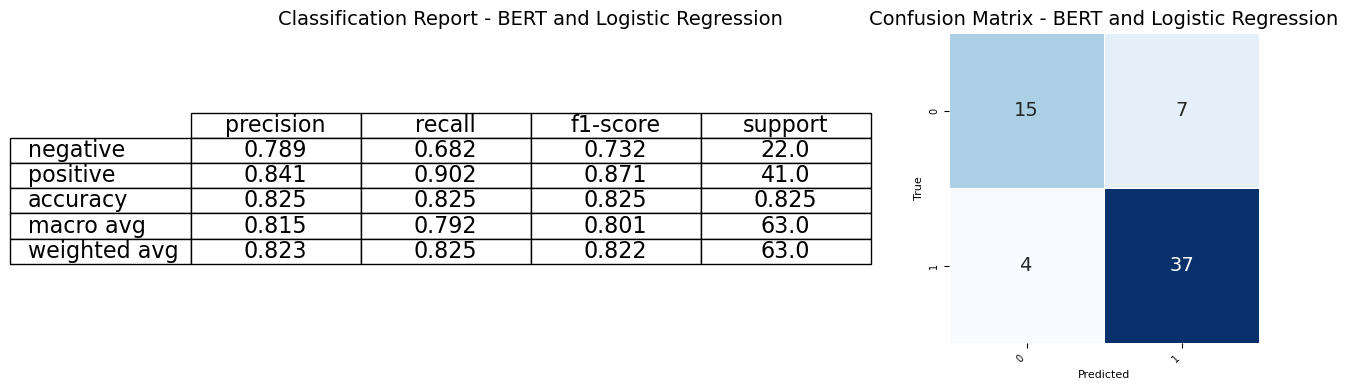

In [109]:
# Initialize and train a logistic regression model
clf = LogisticRegression(max_iter=100, random_state=777)
clf.fit(X_train_embedded, y_train)

# Predict on the test set and evaluate the model
y_pred = clf.predict(X_test_embedded)

get_class_result(y_test, y_pred, 'BERT and Logistic Regression')

- TF-IDF-based Logistic Regression model still performs better

## Compare Different Models

In [139]:
# Encode target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(random_state=777),
    "MultinomialNB": MultinomialNB(),
    "RandomForest": RandomForestClassifier(random_state=777),
    "SVM": SVC(kernel='linear', random_state=777),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=777),
}

results = []

# Train and evaluate each model
for model_name, model in models.items():
    # Fit the model
    if model_name == "MultinomialNB": # MultinomialNB requires non-negative features
        # Transform BERT embeddings to ensure embeddings are non-negative using MinMaxScaler
        scaler = MinMaxScaler()
        X_train_transformed = scaler.fit_transform(X_train_embedded)
        X_test_transformed = scaler.transform(X_test_embedded)
        
        model.fit(X_train_transformed, y_train)
        y_pred = model.predict(X_test_transformed)
    else:
        # Use original embeddings for other models
        model.fit(X_train_embedded, y_train_encoded)
        y_pred = model.predict(X_test_embedded)
        if model_name != "MultinomialNB": # Decode predictions for all other models
            y_pred = label_encoder.inverse_transform(y_pred)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro', zero_division=1)
    
    # Store results
    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Macro F1-Score": macro_f1
    })

results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,Macro F1-Score
0,Logistic Regression,0.825397,0.801148
1,MultinomialNB,0.825397,0.805828
2,RandomForest,0.809524,0.785714
3,SVM,0.825397,0.801148
4,XGBoost,0.857143,0.841132


- XGBoost peformance increased significanlty

## Ensemble Models

Ensemble Models
- Each model learns different patterns in the data, so the more diverse the models, the more likely the ensemble will perform better
- Combining tree-based models and linear models can lead to better results

Used a Voting Classifier with five different models: Logistic Regression, Support Vector Machine (SVM), Random Forest, XGBoost, and K-Nearest Neighbors (KNN).
- applied soft voting (models predict probabilities); the final prediction is based on the weighted average of these probabilities
- giving different weights to the models; prioritized certain models that perform better
- tested both soft and hard voting, and the results showed that soft voting with wegithed worked better for our data

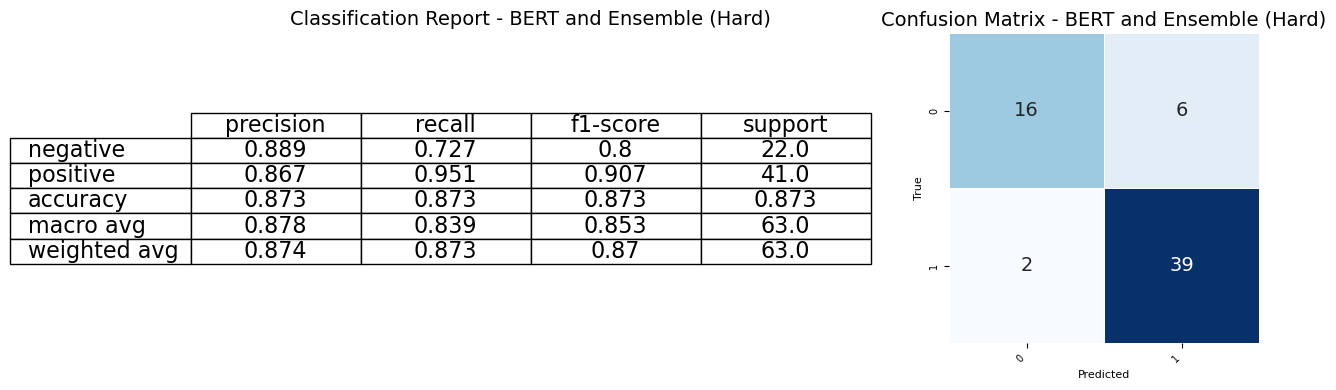

In [111]:
# Apply ensemble methods
classifiers = [
    ('lr', LogisticRegression(max_iter=100, random_state=777)), # Logistic Regression
    ('svm', SVC(random_state=777)), # Support Vector Machine
    ('rf', RandomForestClassifier(n_estimators=100, random_state=777)), # Random Forest
    ('xgb', XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=777)), # XGBoost
    ('knn', KNeighborsClassifier(n_neighbors=5)), # K-Nearest Neighbors
]

# Soft voting ensemble
ensemble_clf = VotingClassifier(
    estimators=classifiers, 
    voting='hard',
    n_jobs=-1
)

# Train ensemble classifier
ensemble_clf.fit(X_train_embedded, y_train)

# Predict and evaluate
y_pred = ensemble_clf.predict(X_test_embedded)

get_class_result(y_test, y_pred, 'BERT and Ensemble (Hard)')

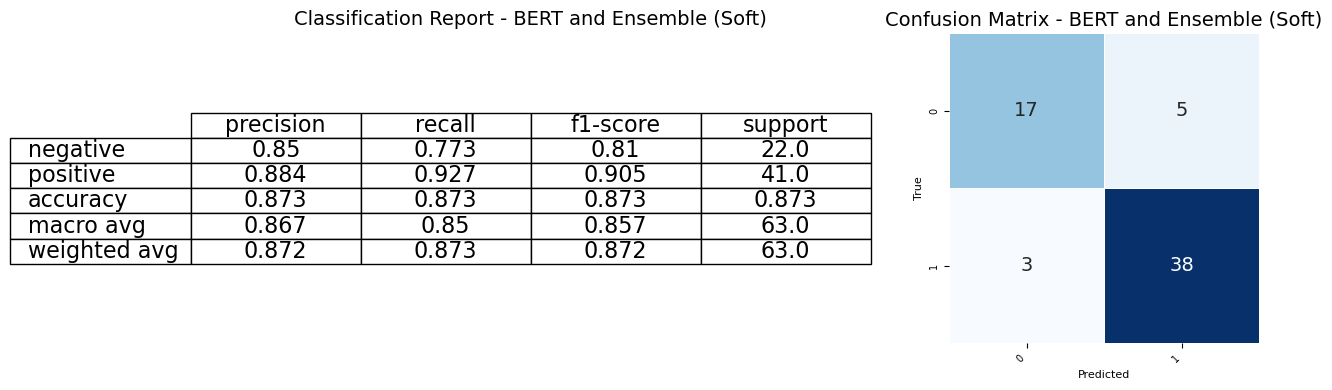

In [112]:
# Apply ensemble methods
classifiers = [
    ('lr', LogisticRegression(max_iter=100, random_state=777)), # Logistic Regression
    ('svm', SVC(probability=True, random_state=777)), # Support Vector Machine
    ('rf', RandomForestClassifier(n_estimators=100, random_state=777)), # Random Forest
    ('xgb', XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=777)), # XGBoost
    ('knn', KNeighborsClassifier(n_neighbors=5)), # K-Nearest Neighbors
]

# Soft voting ensemble
# Adjusting weights to prioritize certain models
ensemble_clf = VotingClassifier(
    estimators=classifiers, 
    voting='soft',
    weights = [1, 2, 3, 3, 2], # Higher weight for Random Forest and XGBoost
    n_jobs=-1
)

# Train ensemble classifier
ensemble_clf.fit(X_train_embedded, y_train)

# Predict and evaluate
y_pred = ensemble_clf.predict(X_test_embedded)

get_class_result(y_test, y_pred, 'BERT and Ensemble (Soft)')

- achieved better performance than the baseline model developed with TF-IDF